In [38]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%matplotlib notebook

In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from regression import OLS
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
z = np.array([1, 2, 1])

# test polynomial fit for simple data
franke_sampled = OLS(x, y, z, 2)


## Plot Franke Function with noise

<IPython.core.display.Javascript object>


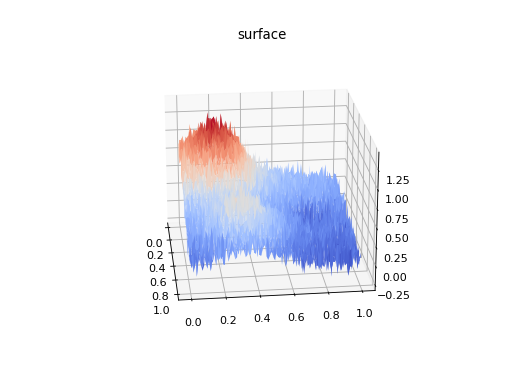

In [44]:
from franke_function import FrankeFunction as Fr
from matplotlib import cm

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], y.shape[1])

z = Fr(x, y) + noise*0.1

ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.set_title('surface');


## Comparing b_0 with subtracted mean 

In [82]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.preprocessing import StandardScaler

polynomial_deg = 2

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.01

sol = OLS(x.ravel(), y.ravel(), z.ravel(), polynomial_deg)
print("Beta with no scaling: ", sol.beta_OLS)

x_cen = (x - np.mean(x))/np.std(x)
y_cen = (y - np.mean(y))/np.std(y)
sol = OLS(x_cen.ravel(), y_cen.ravel(), z.ravel(), polynomial_deg)
print("Beta with standardized x and y: ", sol.beta_OLS)


z_cen = (z - np.mean(z))/np.std(z)
sol_cen = OLS(x_cen.ravel(), y_cen.ravel(), z_cen.ravel(), polynomial_deg)
print("Beta with standardized x, y and z: ", sol_cen.beta_OLS)

scaler = StandardScaler() 

x_cen = scaler.fit_transform(x.reshape(-1, 1))
y_cen = scaler.fit_transform(y.reshape(-1, 1))
z_cen = scaler.fit_transform(z.reshape(-1, 1))

sol_cen = OLS(x_cen.ravel(), y_cen.ravel(), z_cen.ravel(), polynomial_deg)
print("Comparing with SK-Learn: ", sol_cen.beta_OLS)
# Interesting notes: 
# for a polynomial of degree 1 subtracting the mean causes beta[0] to approach zero. 

Beta with no scaling:  [[ 1.26759638]
 [-1.11731071]
 [-0.07356144]
 [-1.43748421]
 [ 2.05100289]
 [ 0.30269436]
 [ 0.38077962]
 [-1.55150153]
 [ 0.08685249]]
Beta with standardized x and y:  [[ 0.42908158]
 [-0.10985999]
 [ 0.00830817]
 [-0.20503934]
 [ 0.07423567]
 [ 0.0093992 ]
 [-0.03116711]
 [-0.03533984]
 [ 0.00060556]]
Beta with standardized x, y and z:  [[ 0.07741427]
 [-0.38217711]
 [ 0.02890218]
 [-0.71328374]
 [ 0.25824849]
 [ 0.0326976 ]
 [-0.10842305]
 [-0.12293901]
 [ 0.0021066 ]]
Comparing with SK-Learn:  [[ 0.07741427]
 [-0.38217711]
 [ 0.02890218]
 [-0.71328374]
 [ 0.25824849]
 [ 0.0326976 ]
 [-0.10842305]
 [-0.12293901]
 [ 0.0021066 ]]


# Predicting Frankes function

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = np.linspace(0, 1, 500)
y = np.linspace(0, 1, 500)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
#z_real = Fr(x, y)
MSE_list = []
for noise_degree in [1.5]:
    z = Fr(x, y) + noise*noise_degree
    
    scaler = StandardScaler() 
    x_cent = scaler.fit_transform(x.reshape(-1, 1))
    y_cent = scaler.fit_transform(y.reshape(-1, 1))
    z_cent = scaler.fit_transform(z.reshape(-1, 1))

    xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]), z_cent)
    
    MSE = []
    for poly_deg in range(1, 15):
        print("Polynomial degree: ", poly_deg)
        model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
        z_prediction = model.predict(xy_cent_test[:, 0], xy_cent_test[:, 1])
        MSE.append(np.sum((z_prediction - z_cent_test)**2))
    MSE_list.append(MSE)

# Observasjonar: Det virker som at polynomene mine treffer ganske bra på franke-funksjonen. 
# Med introduksjon av støy øker bias-variance tradeoff. 
# Kva skjer om eg ikkje sentrerer data? 

Polynomial degree:  1
Polynomial degree:  2
Polynomial degree:  3
Polynomial degree:  4
Polynomial degree:  5
Polynomial degree:  6
Polynomial degree:  7
Polynomial degree:  8
Polynomial degree:  9
Polynomial degree:  10
Polynomial degree:  11
Polynomial degree:  12
Polynomial degree:  13
Polynomial degree:  14


In [118]:
%matplotlib inline

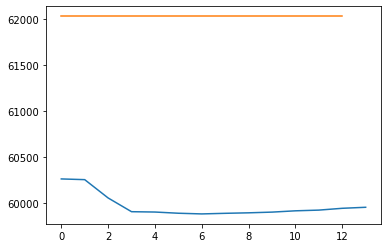

In [20]:
plt.plot(MSE_list[-1]) # sjekk også ut 0, predikert har mindre støy!:) 
stoy = np.var(z_cent_test)*z_cent_test.shape[0] #filtrer ut støyen langs median?
plt.plot([0, 12], [stoy, stoy])
plt.show()

In [22]:
np.std(z_cent_test)

0.9962696431628525

In [137]:
# Uten sentrering av data!




from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = np.linspace(0, 1, 500)
y = np.linspace(0, 1, 500)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
#z_real = Fr(x, y)
MSE_list = []
for noise_degree in [0, 1.5, 3]:
    z = Fr(x, y) + noise*noise_degree
   
    x_cent = x.reshape(-1, 1)
    y_cent = y.reshape(-1, 1)
    z_cent = z.reshape(-1, 1)

    xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]), z_cent)
    
    MSE = []
    for poly_deg in range(1, 15):
        print("Polynomial degree: ", poly_deg)
        model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
        z_prediction = model.predict(xy_cent_test[:, 0], xy_cent_test[:, 1])
        MSE.append(np.sum((z_prediction - z_cent_test)**2))
    MSE_list.append(MSE)

# Observasjonar: Det virker som at polynomene mine treffer ganske bra på franke-funksjonen. 
# Med introduksjon av støy øker bias-variance tradeoff. DEt gir meining da støy gir varians. 

Polynomial degree:  1
Polynomial degree:  2
Polynomial degree:  3
Polynomial degree:  4
Polynomial degree:  5
Polynomial degree:  6
Polynomial degree:  7
Polynomial degree:  8
Polynomial degree:  9
Polynomial degree:  10
Polynomial degree:  11
Polynomial degree:  12
Polynomial degree:  13
Polynomial degree:  14
Polynomial degree:  1
Polynomial degree:  2
Polynomial degree:  3
Polynomial degree:  4
Polynomial degree:  5
Polynomial degree:  6
Polynomial degree:  7
Polynomial degree:  8
Polynomial degree:  9
Polynomial degree:  10
Polynomial degree:  11
Polynomial degree:  12
Polynomial degree:  13
Polynomial degree:  14
Polynomial degree:  1
Polynomial degree:  2
Polynomial degree:  3
Polynomial degree:  4
Polynomial degree:  5
Polynomial degree:  6
Polynomial degree:  7
Polynomial degree:  8
Polynomial degree:  9
Polynomial degree:  10
Polynomial degree:  11
Polynomial degree:  12
Polynomial degree:  13
Polynomial degree:  14


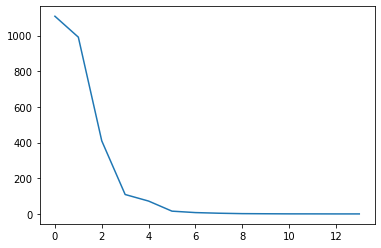

In [139]:
plt.plot(MSE_list[-1]) # sjekk også ut 0
plt.show()

# Reasons for normalizing data

- We do not expect data to be much dependent on 